In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import random as rnd
import time
from copy import deepcopy

%matplotlib inline

In [2]:
def dist(p,q):
    return np.sqrt((q.x-p.x)**2 + (q.y-p.y)**2)
class Point(object):
    def __init__(self, x,y, dist=dist):
        self.x = x
        self.y = y
        self.d = dist
    def angle(self, p):
        try:
            return np.angle((p.x-self.x)+1j*(p.y-self.y))
        except:
            print("error in Point()",p, self)
            return np.angle((p.x-self.x)+1j*(p.y-self.y))
    def distance(self, p):
        return self.d(self,p)
    
    def same_side_of_as(self,l, p):
        r_self = l.a*self.x +l.b*self.y +l.c
        r_p = l.a*p.x +l.b*p.y +l.c
        if r_self*r_p > 0:
            return True
        else:
            return False
    def draw(self, ax, **kwargs):
        ax.scatter([self.x],[self.y], **kwargs)
    def __repr__(self):
        return "("+str(self.x)+", "+str(self.y)+")"

In [3]:
class Line(object):
    def __init__(self, ):
        self.a = self.b = self.c = 1
    def from_param(self,a,b,c):
        if not((a==0 and b==0)):
            self.a = a
            self.b = b
            self.c = c
    def from_points(self, A,B):
        if not (A.x==B.x and A.y==B.y):
            if A.y==B.y:
                self.a=0
                self.c=A.y
                self.b=1
            else:
                self.a = 1
                self.b = -(A.x-B.x)/(A.y-B.y)
                self.c = 0 - (A.x + self.b*A.y)
        else:
            print("Line Error: Same points", A, B)
            return False
    def random_point(self):
        if self.a!=0:
            y = random.random()
            x = -(self.b*y+self.c)/self.a
            return Point(x, y)
        else:
            x = random.random()
            return Point(x, -self.c/self.b)
    def from_pointsbetween(self, A, B):
        x1, y1 = A.x, A.y
        x2, y2 = B.x, B.y
        self.a = -2*(x1-x2)
        self.b = -2*(y1-y2)
        self.c = (x1**2-x2**2)+(y1**2-y2**2)
    def intersection(self, l):
        if (self.a * l.b == self.b * l.a):
            return "parallel"
        else:
            solution = np.linalg.solve(np.matrix([[self.a,self.b],[l.a,l.b]]), -np.matrix([[self.c],[l.c]]))
            r = Point(solution[0,0], solution[1,0])
            return r
      
    def f(self, x):
        if self.b!=0:
            return -(x*self.a+self.c)/self.b
        else:
            return None
    def draw(self, ax, rang, **kwargs):
        ax.plot(rang, [self.f(x) for x in rang], **kwargs)
    #def simmetric_point(self, p):

In [4]:
class Poligon(object):
    def __init__(self, p):
        self.p=p
        self.dots = []
        self.lines = []
        self.dot_names = []
        
    def load_dots(self, dots, dot_names):
        for dot, name in zip(dots, dot_names):
            self.dots.append(deepcopy(dot))
            self.dot_names.append(deepcopy(name))
        try:
            self.dots, self.dot_names =  zip(*sorted(zip(self.dots, self.dot_names), 
                                                    key = lambda var: self.p.angle(var[0])))
        except:
            print("error Poligon: self.dots, self.dot names", self.dots, self.dot_names)
        self.dots = list(self.dots)
        self.dot_names = list(self.dot_names)
        
    def produce_lines_from_dots(self): 
        self.lines.clear()
        for dot in self.dots:
            self.lines.append(Line())
            self.lines[-1].from_pointsbetween(self.p, dot)
            
    def kick_redundant_dots_lines(self):
        redundant_list = []
        i = 0
        while i< len(self.dots):
            redundant = True
            parallel_lines = []
            for j in range(len(self.dots)):
                if j!=i:
                    intersection = self.lines[i].intersection(self.lines[j])
                    intersection_good = True
                    if intersection=="parallel":
                        parallel_lines.append(j)
                    else:    
                        k=0
                        while k < len(self.dots) and intersection_good:
                            if k !=i and k!=j:
                                if not intersection.same_side_of_as(self.lines[k], self.p):
                                    intersection_good=False
                            k+=1
                        if intersection_good:
                            redundant=False
            if not redundant:
                for j in parallel_lines:
                    if not self.p.same_side_of_as(self.lines[j],self.lines[i].random_point()):
                        redundant = True
            if redundant:    
                redundant_list.append(self.dot_names[i])
                del self.lines[i]
                del self.dot_names[i] 
                del self.dots[i]
                
            else:
                i+=1
        return redundant_list

In [5]:
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
def find_centers(X, K,iter_max = 1):
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    iter = 0
    while (not has_converged(mu, oldmu)) and (iter<iter_max):
        iter +=1
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)
    #print(iter)
    return(mu, clusters)

In [ ]:
class structure(object):
    def __init__(self, n_nodes, in_area, h_sigma, sigma = 1,
                 xlim=[-1,1], ylim=[-1,1],  
                 n_sec_max = 100, multiplier=10, 
                 dont_print = True,
                 depth_limit = 3):
        if n_nodes<10:
            return "error, n_nodes<1"
        self.xlim = list(xlim)
        self.ylim = list(ylim)
        self.in_area = in_area
        self.n_nodes = n_nodes
        self.G = nx.Graph()
        self.p=[]
        self.make_points(n_sec_max=n_sec_max, multiplier = 10)
        self.boundary_nodes = []
        self.max_no_edges = 10
        #self.distance = distance
        self.h_sigma = h_sigma
        self.sigma = sigma
        self.dont_print = dont_print
        self.depth_limit = depth_limit
        
    def make_points(self, n_sec_max=100, multiplier =10):
        p=[]
        sections = 1
        not_enough = True
        while not_enough:
            if self.n_nodes/sections**2<n_sec_max:
                not_enough = False
            else:
                sections+=1
        n_per_section = int(self.n_nodes/sections**2)
        for i in range(sections):
            y_lim = (self.ylim[0]+i/sections*(self.ylim[1]-self.ylim[0]),
                     self.ylim[0]+(i+1)/sections*(self.ylim[1]-self.ylim[0]))
            for j in range(sections):
                x_lim = (self.xlim[0]+j/sections*(self.xlim[1]-self.xlim[0]),
                         self.xlim[0]+(j+1)/sections*(self.xlim[1]-self.xlim[0]))
                n=0
                points = []
                while n<n_per_section*multiplier:
                    a, b = np.random.random(size = 2)
                    position = np.array([x_lim[0]+ a*(x_lim[1]-x_lim[0]), y_lim[0]+ b*(y_lim[1]-y_lim[0])])
                    if self.in_area(position):
                        points.append(position)
                        n+=1
                cp = find_centers(points, n_per_section, iter_max=2)  #np.random.random(size = (N,2)))
                p = p + cp[0]
        print("Number of points:", len(p))
        self.n_nodes = len(p)
        for id_n,point in enumerate(p):
            self.p.append(Point(point[0], point[1]))
            
    def make_graph(self):
        self.G = nx.path_graph(self.n_nodes)
        
    def find_closest_inside_graph(self, i, other_than):
        if len(list((self.G.nodes())))>0:
            minj = np.random.choice(list(self.G.nodes()))
            while minj in other_than:
                minj = np.random.choice(list(self.G.nodes()))
        else:
            self.G.add_node(0)
            minj=0
        
        for j, pj in enumerate(self.p):
            if (j in self.G.nodes()) and (j not in other_than):
                if self.p[i].distance(self.p[j])<self.p[i].distance(self.p[minj]):
                    minj = j
        return minj

    def draw_points(self, ):
        fig,ax = plt.subplots(figsize =(10,10))
        plt.scatter([p.x for p in self.p],[p.y for p in self.p])
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
    
    def draw_graph(self ):
        pos = {node:(self.p[node].x,self.p[node].y) for node in self.G.nodes()}
        
        color = []
        for i in range(len(self.p)):
            if self.on_edge(i): 
                color.append("r")
            else:
                color.append("b")
        
        fig,ax = plt.subplots(figsize =(10,10))
        nx.draw_networkx(self.G, 
                         pos = pos,
                         node_color = color, 
                         node_size = 20,
                         with_labels= True)
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        plt.show()
        
    def reconnect_all(self,check_boundary = True):
        for i in self.G.nodes():
            self.reconnect(i, check_boundary = check_boundary)
    
    def reconnect(self,new_node_id):
        close_nodes=[]
        for e in nx.dfs_edges(self.G, source= new_node_id, depth_limit = self.depth_limit):
            close_nodes.append(e[1])
        d = []
        for close_node in close_nodes:
            d_i = self.p[new_node_id].distance(self.p[close_node])
            d.append(d_i)
            d.sort()
            if len(d)>self.max_no_edges:
                d = d[:self.max_no_edges]
        
        for close_node in close_nodes:
            if self.p[close_node].distance(self.p[new_node_id])<=d[-1]:
                if not close_node in nx.all_neighbors(self.G, new_node_id):
                    self.G.add_edge(close_node, new_node_id)
                    self.reconnect(close_node)
            else:
                if close_node in nx.all_neighbors(self.G, new_node_id):
                    self.G.remove_edge(close_node, new_node_id)
        self.boundary_nodes.append(new_node_id)
    
    def reconnect_all_spatially(self):
        for i in self.G.nodes():
            self.reconnect_spatially(i)
    
    def reconnect_spatially(self, i):
        
        neighbours = list(nx.all_neighbors(self.G, i))
        if neighbours!=[]:
            for j in neighbours:
                self.G.remove_edge(i,j)
        #its a solo point:
        other_than = [i]
        for junk in range(5):
            j = self.find_closest_inside_graph(i, other_than)
            other_than.append(j)
            
        for j in other_than[1:]:
            self.G.add_edge(i,j)
        self.reconnect_properly_depth(i,depth = 3)
        
    def reconnect_properly(self, i,  pool):
        if pool == []:
            self.reconnect_spatially(i)
        else:
            points = []
            for cn in pool:
                points.append(self.p[cn])
            poli = Poligon(self.p[i])

            poli.load_dots(points, pool)
            poli.produce_lines_from_dots()

            redundant_names = poli.kick_redundant_dots_lines()

            for j in pool:    
                if j in redundant_names or self.p[j].distance(self.p[i])>self.sigma*10:
                    self.G.add_edge(i,j)
                    self.G.remove_edge(i, j)
                    if list(self.G.neighbors(j)) == []:
                        self.reconnect_spatially(j)
                else:
                    self.G.add_edge(i, j)
        self.boundary_check(pool+[i])
    
    def reconnect_properly_depth(self, i, depth):
        pool = []
        for e in nx.dfs_edges(self.G, source= i, depth_limit = depth):
                pool.append(e[1])
        self.reconnect_properly(i,pool)
    
    def reconnect_all_properly(self):
        for i in self.G.nodes():
            close_nodes=[]
            for e in nx.dfs_edges(self.G, source= i, depth_limit = self.depth_limit):
                close_nodes.append(e[1])
            self.reconnect_properly(i,close_nodes)
    
    def on_edge(self, i):
        #reconnect properly:
        
        if not self.dont_print: print("On edge started, point ", i)
        
        # check if it is on edge
        # it is on the edge if any of the limiting lines is not redundant.
        neighbours = list(nx.all_neighbors(self.G, i))
        points = []
        for neighbour in neighbours:
            points.append(self.p[neighbour])
        
        add_points = [Point(2*self.xlim[0]-self.p[i].x, self.p[i].y),
                      Point(2*self.xlim[1]-self.p[i].x, self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[0]-self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[1]-self.p[i].y)]
        for j, a_p in enumerate(add_points):    
            a_p_name = -j-1
            poli = Poligon(self.p[i])
            poli.load_dots([a_p]+points, [a_p_name]+neighbours)
            poli.produce_lines_from_dots()
        
            redundant_names = poli.kick_redundant_dots_lines()
            if not self.dont_print: print(a_p_name)
            if a_p_name not in redundant_names:
                if not self.dont_print: print("point ", i , " is on edge ",a_p_name, a_p.x, a_p.y)
                return True
        return False
    def boundary_check(self,pool):
        for i in pool:
            if i in self.boundary_nodes:
                if not self.on_edge(i):
                    self.boundary_nodes.remove(i)
            else:
                if self.on_edge(i):
                    self.boundary_nodes.append(i)
            
    def start_graph(self, n_nodes):
        self.p = []
        self.boundary_nodes = []
        self.G.clear()
        n=0
        if len(list(self.G.nodes()))<3:
            self.G.add_node(0)
            self.p.append(Point(0,0))
            self.G.add_node(1)
            x,y = self.generate_new_xy(0,0)
            self.p.append(Point(x,y))
            self.G.add_edge(0,1)
            if x<self.xlim[0]:
                self.xlim[0] = x-self.sigma
            if x>self.xlim[1]:
                self.xlim[1] = x+self.sigma
            if y<self.ylim[0]:
                self.ylim[0] = y-self.sigma
            if y>self.ylim[1]:
                self.ylim[1] = y+self.sigma
            
            self.boundary_nodes.append(0)
            self.boundary_nodes.append(1)
            
            n = 2
        while n<n_nodes:
            prox_node = np.random.choice(self.boundary_nodes)

            x,y = self.generate_new_xy(self.p[prox_node].x, self.p[prox_node].y)

            if x<self.xlim[0]:
                self.xlim[0] = x-self.sigma
            if x>self.xlim[1]:
                self.xlim[1] = x+self.sigma
            if y<self.ylim[0]:
                self.ylim[0] = y-self.sigma
            if y>self.ylim[1]:
                self.ylim[1] = y+self.sigma
            
            self.G.add_node(n)
            self.p.append(Point(x,y))
            self.G.add_edge(prox_node, n)
            
            close_nodes=[]
            for e in nx.dfs_edges(self.G, source= n, depth_limit = self.depth_limit):
                close_nodes.append(e[1])
            self.reconnect_properly(n, close_nodes)
            n+=1
    def grow_graph(self, n_nodes):
        #self.p = []
        #self.boundary_nodes = []
        #self.G.clear()
        n0=len(self.p)
        n = n0
        if len(list(self.G.nodes()))<3:
            print("Start graph first pls.")
        while n<n_nodes+n0:
            prox_node = np.random.choice(self.boundary_nodes)

            x,y = self.generate_new_xy(self.p[prox_node].x, self.p[prox_node].y)

            if x<self.xlim[0]:
                self.xlim[0] = x-self.sigma
            if x>self.xlim[1]:
                self.xlim[1] = x+self.sigma
            if y<self.ylim[0]:
                self.ylim[0] = y-self.sigma
            if y>self.ylim[1]:
                self.ylim[1] = y+self.sigma
            
            self.G.add_node(n)
            self.p.append(Point(x,y))
            self.G.add_edge(prox_node, n)
            
            close_nodes=[]
            for e in nx.dfs_edges(self.G, source= n, depth_limit = self.depth_limit):
                close_nodes.append(e[1])
            self.reconnect_properly(n, close_nodes)
            for e in nx.dfs_edges(self.G, source= n, depth_limit = self.depth_limit):
                close_nodes.append(e[1])
            self.reconnect_properly(n, close_nodes)
            for i in self.boundary_nodes:
                if not self.on_edge(i):
                    self.boundary_nodes.remove(i)
            if self.on_edge(n):
                self.boundary_nodes.append(n)
            n+=1

    def generate_new_xy(self, x0, y0):
        rx = np.random.randn()
        ry = np.random.randn()
        f = lambda x: -(np.abs(x)+0.5)*np.sign(x)
        x = x0 + f(rx)*self.sigma
        y = y0 + f(ry)*self.sigma
        return x,y

In [ ]:
s = structure(10, area, 10, depth_limit=3)

In [ ]:
s.start_graph(10)

In [ ]:
#s.grow_graph(10)
s.draw_graph()

In [ ]:
s.grow_graph(50)
s.draw_graph()

In [ ]:
s.grow_graph(20)
s.draw_graph()

In [ ]:
s.reconnect_spatially(12)
#s.reconnect_properly_depth(12,depth =1)


In [ ]:
s.draw_graph()

for i in range(len(s.p)):
    s.reconnect_spatially(i)

s.reconnect_all_properly()

In [ ]:
f = lambda x: -(np.abs(x)+0.5)*np.sign(x)
plt.hist(f(np.random.normal(size = 20000)), bins = 100, range = (-5,5))
plt.show()

In [183]:
%load_ext snakeviz

In [252]:
class structure(object):
    def __init__(self, n_nodes, in_area, h_sigma, sigma = 1,
                 xlim=[-1,1], ylim=[-1,1],  
                 n_sec_max = 100, multiplier=10, 
                 dont_print = True,
                 depth_limit = 3):
        self.dont_print = dont_print
        
        if n_nodes<4:
            print("error, n_nodes<1")
        self.xlim = list(xlim)
        self.ylim = list(ylim)
        self.in_area = in_area
        self.n_nodes = n_nodes
        self.G = nx.Graph()
        self.p=[]
        self.boundary_nodes = set()
        self.max_no_edges = 10
        #self.distance = distance
        self.h_sigma = h_sigma
        self.sigma = sigma
        
        self.depth_limit = depth_limit
        
        self.n_per_section = 0
        
    def make_points(self, n_sec_max=100, multiplier =10):
        p=[]
        sections = 1
        not_enough = True
        while not_enough:
            if self.n_nodes/sections**2<n_sec_max:
                not_enough = False
            else:
                sections+=1
        self.n_per_section = int(self.n_nodes/sections**2)
        for i in range(sections):
            y_lim = (self.ylim[0]+i/sections*(self.ylim[1]-self.ylim[0]),
                     self.ylim[0]+(i+1)/sections*(self.ylim[1]-self.ylim[0]))
            for j in range(sections):
                x_lim = (self.xlim[0]+j/sections*(self.xlim[1]-self.xlim[0]),
                         self.xlim[0]+(j+1)/sections*(self.xlim[1]-self.xlim[0]))
                
                points = []
                for n in range(self.n_per_section*multiplier):
                    a, b = np.random.random(size = 2)
                    position = np.array([x_lim[0]+ a*(x_lim[1]-x_lim[0]), y_lim[0]+ b*(y_lim[1]-y_lim[0])])    
                    points.append(position)
                
                cp = find_centers(points, self.n_per_section, iter_max=2)  #np.random.random(size = (N,2)))
                filtered_centers = []
                for point in cp[0]:
                    if self.in_area(point):
                        filtered_centers.append(point)
                p = p + filtered_centers
        print("Number of points:", len(p))
        self.n_nodes = len(p)
        for id_n,point in enumerate(p):
            self.p.append(Point(point[0], point[1]))
            
    def make_graph(self):
        self.G = nx.Graph()
        self.G.add_edge(0,1)
        self.G.add_edge(2,1)
        self.G.add_edge(0,2)
        self.boundary_nodes = set([0,1,2])
        for i,p in enumerate(self.p):
            if i>2:
                proxy  = self.find_closest_inside_graph_fast(i)
                self.G.add_node(i)
                self.G.add_edge(i, proxy)
                #self.reconnect_spatially( i, with_proxy = True, proxy = proxy, check_boundary = False)    
                if not self.dont_print: print("proxy", proxy)
                self.reconnect_properly_depth(i,depth_limit = 3, check_boundary=False, with_edge=True)
                self.boundary_check(self.G.neighbors(i))
                if self.on_edge(i):
                    self.boundary_nodes.add(i)
                
                
                if not self.dont_print: self.draw_graph()
                
                
    def find_closest_inside_graph(self, i, other_than, pool = -1):
        if pool == -1:
            pool = list(self.G.nodes())
        actual_pool = []
        for i in pool:
            if i not in other_than:
                actual_pool.append(i)
                
        if len(actual_pool)>0:
            minj = np.random.choice(actual_pool)
            for j in actual_pool:
                if self.p[i].distance(self.p[j])<self.p[i].distance(self.p[minj]):
                    minj = j
            return minj
        else:
            return -1
        

    def find_closest_inside_graph_fast(self, i):
        pool = list(self.G.nodes())        
        if len(pool)>0:
            closest_found = []
            for k in range(5):
                minj = np.random.choice(pool)
                found = False
                while not found:
                    nodes = self.G.neighbors(minj)
                    new_minj = minj
                    for j in nodes:
                        if self.p[i].distance(self.p[j])<self.p[i].distance(self.p[minj]):
                            if i!=j:
                                new_minj = j
                    if minj==new_minj:
                        found = True
                    else:
                        minj=new_minj
                closest_found.append(minj)
            if not self.dont_print: print("find_closest_fast: closest_found, ", closest_found)
            minj = closest_found[0]
            for j in closest_found[1:]:
                if self.p[i].distance(self.p[j])<self.p[i].distance(self.p[minj]):
                    minj = j
            return  minj
        else:
            return -1
    def draw_points(self, ):
        fig,ax = plt.subplots(figsize =(8,8))
        plt.scatter([p.x for p in self.p],[p.y for p in self.p])
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
    
    def draw_graph(self, ax = -1, **kwargs ):
        pos = {node:(self.p[node].x,self.p[node].y) for node in self.G.nodes()}
        
        color = []
        for i in range(len(self.p)):
            if i in self.boundary_nodes: 
                color.append("r")
            else:
                color.append("b")
        my_figure = False
        if ax == -1:
            my_figure = True
            fig,ax = plt.subplots(figsize =(8,8))
        nx.draw_networkx(self.G, 
                         pos = pos,
                         node_color = color, 
                         node_size = 180,
                         with_labels= True,
                         font_size = 17,
                         **kwargs)
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        
        if my_figure: plt.show()
        
    def reconnect_all_spatially(self, pool=-1, check_boundary = True):
        if pool == -1:
            pool = self.G.nodes()
            
        for i in pool:
            self.reconnect_spatially(i,check_boundary = check_boundary)
    
    def reconnect_spatially(self, i, with_proxy = False, proxy = 0, with_edge=False, last = False, check_boundary = True):
        if not self.dont_print: print("reconnect_spatially:\n i,",i,
                                      ", with_proxy, ", with_proxy,
                                      ",proxy,",  proxy,
                                      " with_edge,", with_edge,
                                      " last,", last,
                                      "check_boundary, ",check_boundary)
        if with_proxy:
            neighbours = list(nx.all_neighbors(self.G, i))
            if neighbours!=[]:
                for j in neighbours:
                    self.G.remove_edge(i,j)
            #its a solo point:
            other_than = [i, proxy]
            
            close_nodes=set()
            for e in nx.dfs_edges(self.G, source= proxy, depth_limit = self.depth_limit):
                close_nodes.add(e[1])
            if with_edge:
                close_nodes = close_nodes.union(self.boundary_nodes)
            close_nodes = list(close_nodes)
            no_of_edges = 1
            end_of_nodes = False
            while no_of_edges<6 and not end_of_nodes:
                j = self.find_closest_inside_graph(i, other_than, pool = close_nodes)
                if j != -1:
                    other_than.append(j)
                else:
                    end_of_nodes = True
                    
            for j in other_than[1:]:
                self.G.add_edge(i,j)
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
            
        else:
            neighbours = list(nx.all_neighbors(self.G, i))
            if neighbours!=[]:
                for j in neighbours:
                    self.G.remove_edge(i,j)
            #its a solo point:
            other_than = [i]
            no_of_edges = 0
            end_of_nodes = False
            while no_of_edges<6 and not end_of_nodes:
                j = self.find_closest_inside_graph(i, other_than)
                if j != -1:
                    other_than.append(j)
                else:
                    end_of_nodes = True
            for j in other_than[1:]:
                self.G.add_edge(i,j)
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
        
    def reconnect_properly_depth(self, i, depth_limit = -1, last = False, check_boundary = True, with_edge=False):
        if not self.dont_print: print("reconnect_properly_depth:\n i, ",i,
                                      ", depth_limit, ", depth_limit,
                                      ", last, ", last,
                                      ", check_boundary, ",check_boundary,
                                      ", with_edge, ", with_edge)
        
        if depth_limit ==-1:
            depth_limit = self.depth_limit
        close_nodes=set()
        for e in nx.dfs_edges(self.G, source= i, depth_limit = depth_limit):
            close_nodes.add(e[1])
        if with_edge:
            close_nodes = close_nodes.union(self.boundary_nodes)
        close_nodes= list(close_nodes)
        self.reconnect_properly(i,close_nodes, last= last, check_boundary= check_boundary)
        
    def reconnect_properly(self, i,  pool, last = False, check_boundary = True):
        if not self.dont_print: print("reconnect_properly:\n i, ",i,
                                      ", pool, ", pool,
                                      ", last, ", last,
                                      ", check_boundary, ",check_boundary)
        if pool == []:
            self.reconnect_spatially(i, last = last, check_boundary = check_boundary)
        else:
            points = []
            for cn in pool:
                try:
                    points.append(self.p[cn])
                except:
                    print("error, reconnect properly", pool)
            poli = Poligon(self.p[i])
            
            poli.load_dots(points, pool)
            poli.produce_lines_from_dots()

            redundant_names = poli.kick_redundant_dots_lines()
            b_check=[]
            lost_all_edges = []
            may_have_too_many_edges=[]
            for j in pool:
                if j in redundant_names:# or self.p[j].distance(self.p[i])>self.sigma*10:
                    if self.G.has_edge(i,j):
                        self.G.remove_edge(i, j)
                        if list(self.G.neighbors(j)) == []:
                            lost_all_edges.append(j)
                else:
                    self.G.add_edge(i, j)
                    b_check.append(j)
                    may_have_too_many_edges.append(j)
                    
            for j in set(may_have_too_many_edges):
                if not last: 
                    self.reconnect_properly_depth(j,depth_limit=1, last = True ,check_boundary = check_boundary)
            for j in set(lost_all_edges):
                self.reconnect_spatially(j ,check_boundary = check_boundary, last = last)
            
            if check_boundary:
                self.boundary_check(b_check)
                if self.on_edge(i):
                    self.boundary_nodes.add(i)
    
    def reconnect_all_properly(self, last = False, check_boundary = True):
        for i in self.G.nodes():
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
    
    def on_edge(self, i):
        if not self.dont_print: print("On edge started, point ", i)
        
        # check if it is on edge
        # it is on the edge if any of the limiting lines is not redundant.
        neighbours = list(nx.all_neighbors(self.G, i))
        points = []
        for neighbour in neighbours:
            points.append(self.p[neighbour])
        
        add_points = [Point(2*self.xlim[0]-self.p[i].x, self.p[i].y),
                      Point(2*self.xlim[1]-self.p[i].x, self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[0]-self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[1]-self.p[i].y)]
        for j, a_p in enumerate(add_points):    
            a_p_name = -j-1
            poli = Poligon(self.p[i])
            poli.load_dots([a_p]+points, [a_p_name]+neighbours)
            poli.produce_lines_from_dots()
        
            redundant_names = poli.kick_redundant_dots_lines()
            if not self.dont_print: print(a_p_name)
            if a_p_name not in redundant_names:
                if not self.dont_print: print("point ", i , " is on edge ",a_p_name, a_p.x, a_p.y)
                return True
        return False
    
    def boundary_check2(self,pool):
        for i in pool:
            oe = self.on_edge(i)
            if i in self.boundary_nodes:
                if not oe:
                    self.boundary_nodes.remove(i)
            else:
                if oe:
                    self.boundary_nodes.add(i)
    def boundary_check(self,pool):
        for i in pool:
            if i in self.boundary_nodes:
                oe = self.on_edge(i)
                if not oe:
                    self.boundary_nodes.remove(i)
    
    def limit_check(self, x,y):
        if x<self.xlim[0]:
            self.xlim[0] = x-self.sigma
        if x>self.xlim[1]:
            self.xlim[1] = x+self.sigma
        if y<self.ylim[0]:
            self.ylim[0] = y-self.sigma
        if y>self.ylim[1]:
            self.ylim[1] = y+self.sigma
    
    def start_graph(self, n_nodes):
        self.p = []
        self.boundary_nodes.clear()
        self.G.clear()
        n=0
        
        self.G.add_node(0)
        self.p.append(Point(0,0))
        
        self.G.add_node(1)
        x,y = self.generate_new_xy(0,0)
        self.p.append(Point(x,y))
        
        self.G.add_edge(0,1)
        
        self.limit_check(x,y)

        self.boundary_nodes.add(0)
        self.boundary_nodes.add(1)

        n = 2
        while n<n_nodes:
            prox_node = np.random.choice(list(self.boundary_nodes))

            x,y = self.generate_new_xy(self.p[prox_node].x, self.p[prox_node].y)
            self.limit_check(x,y)
            
            self.G.add_node(n)
            self.p.append(Point(x,y))
            self.G.add_edge(prox_node, n)
            
            self.reconnect_spatially(n,with_proxy = True, proxy = prox_node, with_edge = True)
            n+=1
            
    def grow_graph(self, n_nodes):
        
        n0=len(self.p)
        n = n0
        if len(list(self.G.nodes()))<3:
            print("Start graph first pls.")
        while n<n_nodes+n0:
            prox_node = np.random.choice(list(self.boundary_nodes))

            x,y = self.generate_new_xy(self.p[prox_node].x, self.p[prox_node].y)
            self.limit_check(x,y)
            
            self.G.add_node(n)
            self.p.append(Point(x,y))
            self.G.add_edge(prox_node, n)
            
            self.reconnect_spatially(n,with_proxy = True, proxy = prox_node)
            n+=1
            

    def generate_new_xy(self, x0, y0):
        rx = np.random.randn()
        ry = np.random.randn()
        f = lambda x: -(np.abs(x)+0.5)*np.sign(x)
        x = x0 + f(rx)*self.sigma
        y = y0 + f(ry)*self.sigma
        return x,y

In [101]:
s= structure(15,area,0,depth_limit=3)


In [ ]:
%%timeit -n 1 -r 1
s.start_graph(10)
s.draw_graph()

In [ ]:
s.boundary_nodes

In [ ]:
%%timeit -n 1 -r 1
s.grow_graph(50)
s.draw_graph()

In [263]:
r = 10
def area(x):
    return np.sqrt(x[0]**2+x[1]**2) <r
s= structure(500,area,0,depth_limit=3, xlim=(-5,5), ylim=(-5,5))#, dont_print = False)

In [264]:
s.make_points()
#s.draw_points()

Number of points: 495


In [265]:
%%timeit -n 1 -r 1

#%%snakeviz

s.make_graph()

1 loops, best of 1: 2min 44s per loop


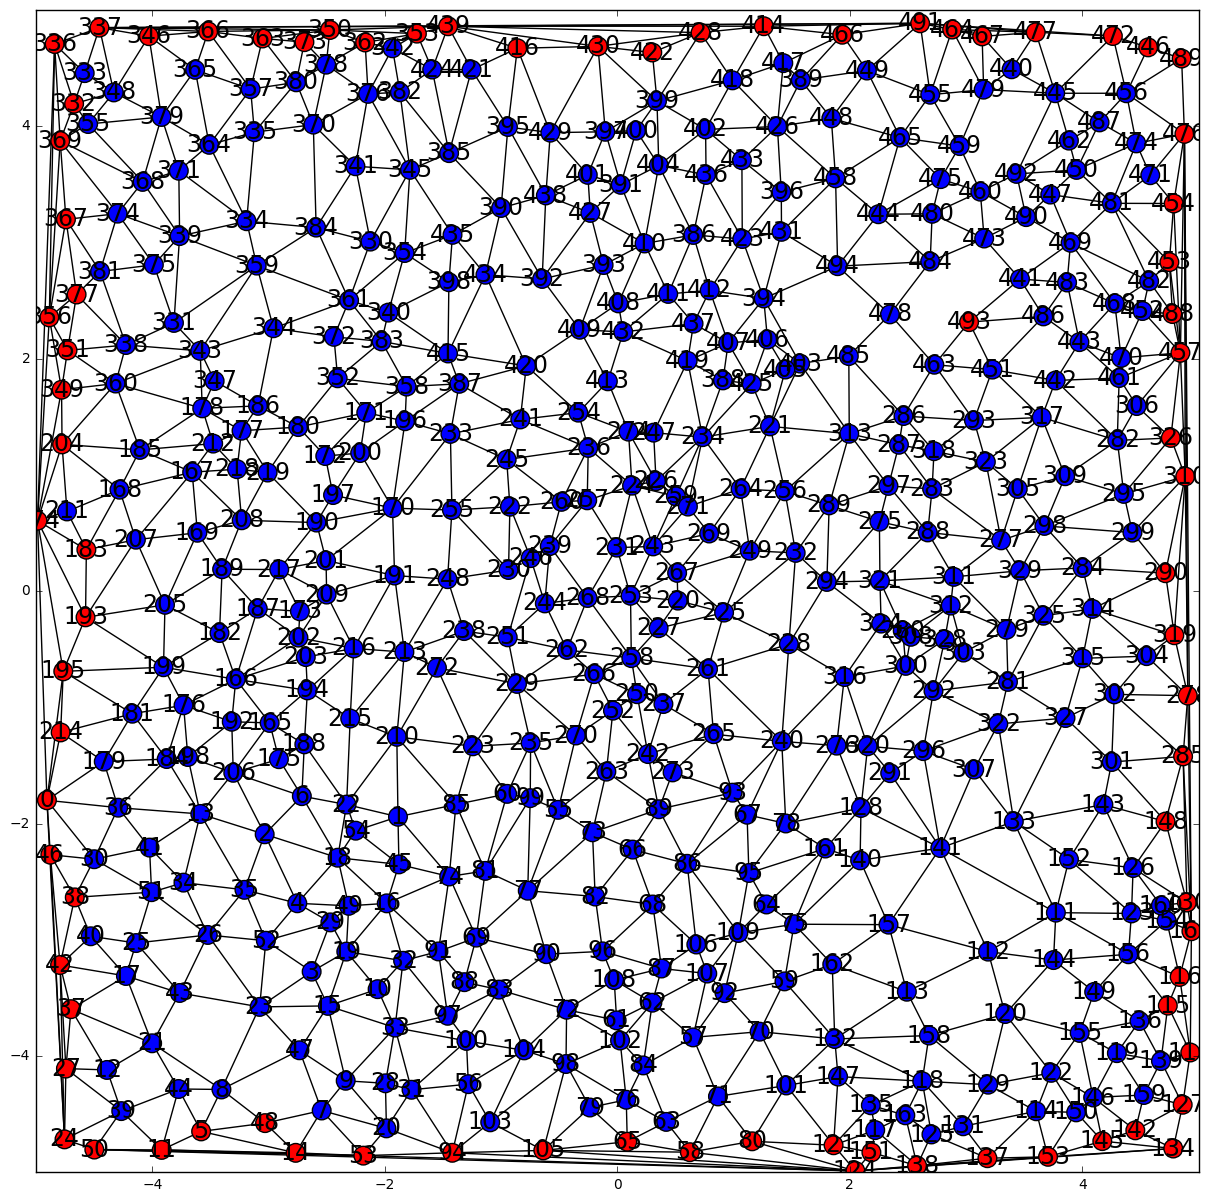

In [271]:
fig,ax = plt.subplots(figsize = (15,15))
s.draw_graph(ax = ax)
#x = np.linspace(-r,r,100)
#y = np.sqrt(r**2-x**2)
#print(x,y)
#ax.plot(x, y, c = "k")
#ax.plot(x, -y, c = "k")
plt.show()

In [267]:
x = [ 50, 100,  200, 300, 500]
y = [5.3,  13,  43.9, 96.7, 164]


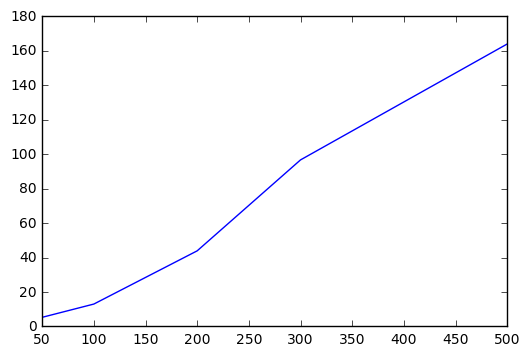

In [268]:
plt.plot(x,y)

In [ ]:
s.draw_graph()